# Classification
The AudioMNIST dataset contains recordings of spoken digits (0-9) by 60 speakers, with a total of 30,000 audio samples.

This notebook trains a ResNet50 instance to predict the spoken digit from each recording, based on spectrogram representations obtained by short-time Fourier transformations of the recorded waveforms. The trained network is evaluated against 12 (20%) of the speakers, withheld as validation set from training.

In [1]:
### Download AudioMNIST data
!wget https://github.com/soerenab/AudioMNIST/archive/refs/heads/master.zip
!unzip master.zip > /dev/null 2>&1 # Hide output

--2023-02-22 17:31:38--  https://github.com/soerenab/AudioMNIST/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/soerenab/AudioMNIST/zip/refs/heads/master [following]
--2023-02-22 17:31:38--  https://codeload.github.com/soerenab/AudioMNIST/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.121.9
Connecting to codeload.github.com (codeload.github.com)|140.82.121.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [               <=>  ] 948.50M  7.21MB/s    in 2m 17s  

2023-02-22 17:33:56 (6.92 MB/s) - ‘master.zip’ saved [994575418]



In [2]:
### Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
import torch.optim as optim
import torch.nn as nn
from torch.utils import data
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix
from IPython.display import Audio

In [3]:
### Find all .wav files
path_in = "AudioMNIST-master/data/"
paths_wav = []

for path, subdirs, files in os.walk(path_in):
    for name in files:
        if ".wav" in name:
          paths_wav.append(os.path.join(path, name))

# Extract digit label from file names
labels = [os.path.basename(f).split("_")[0] for f in paths_wav]
labels = np.array(labels).astype(np.uint8)

In [4]:
### Define parameters for short-time fourier transform
stft_param = {}
stft_param["nfft"] = 256
stft_param["hop"] = stft_param["nfft"] // 2
stft_param["signal_length"] = 48000

In [5]:
### Convert waveform to spectrogram using short-time fourier transform
def wav_to_stft_spectrogram(signal, stft_param):

  max_length = stft_param["signal_length"]

  # Pad or crop signal to desired length
  dif = max_length - len(signal)
  if dif > 0:
      signal = np.hstack((signal, np.zeros(dif)))
  else:
      signal = signal[:max_length]

  # Get spectrogram
  S = librosa.stft(signal, n_fft=stft_param["nfft"], hop_length=stft_param["hop"])
  D = librosa.amplitude_to_db(np.abs(S), ref=np.max)

  return D      

Text(0, 0.5, 'Frequency (kHz)')

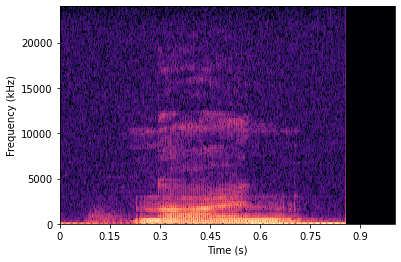

In [6]:
### Visualize spectrogram for one image
wav_idx = 15
signal, sr = librosa.load(paths_wav[wav_idx], sr=None)
D = wav_to_stft_spectrogram(signal, stft_param)

f, ax = plt.subplots(1, 1)

spec = librosa.display.specshow(D, 
          x_axis='time', 
          y_axis='linear', 
          sr=sr, 
          hop_length=stft_param["hop"],
          ax=ax,
          cmap='magma',
          vmin=np.min(D),
          vmax=0) 
ax.set_xlabel('Time (s)')
ax.set_ylabel('Frequency (kHz)')

# Uncomment to listen to visualized clip
#wn = Audio(paths_wav[wav_idx], autoplay=True)
#display(wn)

In [7]:
##### Create randomized training/validation split on speaker level

# Determine speaker of each sample from filename
speakers = [os.path.basename(f.split("_")[1]) for f in paths_wav]

paths_wav = np.array(paths_wav)
speakers = np.array(speakers)

# Isolate unique speaker IDs
speakers_uq = np.unique(speakers)
S = len(speakers_uq)

# Select random speakers
np.random.shuffle(speakers_uq)

train_share = 0.8
first_val = int(S * train_share)

speakers_train = speakers_uq[:first_val]
speakers_val = speakers_uq[first_val:]

# Split samples according to speaker selection
mask_train = np.in1d(speakers, speakers_train)
paths_wav_train = paths_wav[mask_train]
labels_train = labels[mask_train]

mask_val = np.in1d(speakers, speakers_val)
paths_wav_val = paths_wav[mask_val]
labels_val = labels[mask_val]

print(f"Split {len(paths_wav)} samples in to {len(paths_wav_train)} vs {len(paths_wav_val)} train/val")

Split 30000 samples in to 24000 vs 6000 train/val


In [8]:
### Plotting loss curves
def plot_losses(losses_train, losses_val, losses_val_it):

  losses_train = np.array(losses_train).astype("float")
  losses_val = np.array(losses_val).astype("float")
  
  # Plot losses
  plt.close()
  clear_output()    

  f, ax1 = plt.subplots(figsize = (12, 4)) 

  ax1.plot(losses_train)
  ax1.set_ylabel("Training loss", color="C0")

  ax2 = ax1.twinx()
  ax2.plot(losses_val_it, losses_val, color="C1")
  ax2.set_ylabel("Validation loss", color="C1")

  ax1.grid(True, axis="y")
  plt.show()

In [9]:
### Data loader
class LabeledSpectrogramDataset(data.Dataset):
 
    def __init__(self, paths_wav, labels, stft_param, do_augment):
        self.paths_wav = paths_wav
        self.labels = labels
        self.stft_param = stft_param
        self.do_augment = do_augment

    def __len__(self):
        return len(self.paths_wav)

    def __getitem__(self, index):

        signal, sr = librosa.load(self.paths_wav[index], sr=None)
        Y = int(self.labels[index])
    
        D = wav_to_stft_spectrogram(signal, self.stft_param)

        # Normalize 
        D = (D - np.amin(D)) / (np.amax(D) - np.amin(D))

        # Strip highest frequency to get shape with power of two
        D = D[:-1, :]

        # Add dummy channel for shape C x H x W
        D = D[np.newaxis, ...]

        # Replicate to 3 channels to benefit from pre-trained weights
        D = np.vstack((D, D, D))    

        # Convert to pytorch tensor
        X = Variable(torch.from_numpy(D)).float()

        name = os.path.basename(self.paths_wav[index])

        return X, Y, name

In [10]:
def get_data_loader(paths_wav, labels, stft_param, B, do_shuffle, do_augment):
  dataset = LabeledSpectrogramDataset(paths_wav, labels, stft_param, do_augment)
  loader = torch.utils.data.DataLoader(dataset,
                                    num_workers=1,
                                    batch_size=B,
                                    shuffle=do_shuffle,
                                    pin_memory=True,
                                    # use different random seeds for each worker
                                    # courtesy of https://github.com/xingyizhou/CenterNet/issues/233
                                    worker_init_fn = lambda id: np.random.seed(torch.initial_seed() // 2**32 + id) )

  return loader

In [11]:
### Get pre-trained ResNet50
def initialize_network(class_count):

  net = resnet50(weights=ResNet50_Weights.DEFAULT)
  net.fc = nn.Linear(net.fc.in_features, class_count)

  return net

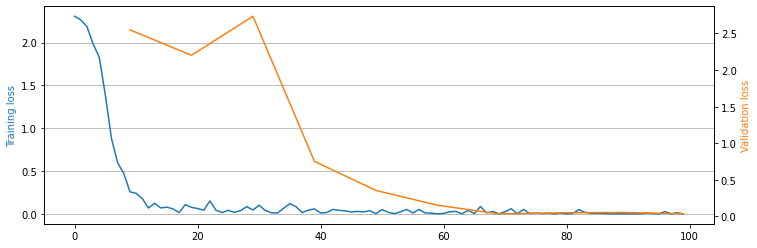

In [14]:
### Train network
net = initialize_network(class_count = 10)

B = 128 # batch size

lr = 0.001 # learning rate
lr_exponent = 0.9 # exponent for poly learning rate policy

I = 100 # training iterations
I_val = 10 # validate after this many iterations

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=lr)

# Get training data loader
loader_train = get_data_loader(paths_wav_train, labels_train, stft_param, B, do_shuffle=True, do_augment=True)
loader_val = get_data_loader(paths_wav_val, labels_val, stft_param, B, do_shuffle=False, do_augment=False)

#
net.train()
net = net.cuda()

losses_train = []

losses_val = [] # Mean loss across full validation set
losses_val_it = [] # Iteration index of validation loss values

i = 0
while i < I:

    for X, Y, _ in loader_train:

        if i >= I: break
        i += 1

        X = X.cuda(non_blocking=True)
        Y = Y.cuda(non_blocking=True)

        optimizer.zero_grad()

        outputs = net(X)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        losses_train.append(loss.detach().item())

        # Use poly learning policy
        lr_i = optimizer.param_groups[0]['lr'] 
        optimizer.param_groups[0]['lr'] = lr * (1 - i / I)**lr_exponent

        # Validate at current snapshot        
        if i > 1 and (i % I_val) == 0:
            
            net.eval()

            with torch.no_grad():

              losses_val_snapshot = []

              for X, Y, name in loader_val:

                X = X.cuda(non_blocking=True)
                Y = Y.cuda(non_blocking=True)    

                outputs = net(X)
                loss = criterion(outputs, Y)    

                losses_val_snapshot.append(loss.detach().item())
              
              # Aggregate to mean validation loss at current snapshot
              losses_val.append(np.mean(losses_val_snapshot))
              losses_val_it.append(i-1)

              plot_losses(losses_train, losses_val, losses_val_it)
            
            net.train()

In [15]:
### Validate with more detail
def evaluate(net, data_loader):
  with torch.no_grad():

    net.eval()

    class_count = 10

    all_gt = [] # Spoken digits
    all_out = [] # Predicted digits

    count = 0
    for X, Y, _ in data_loader:

      X = X.cuda(non_blocking=True)
      Y = Y.cuda(non_blocking=True)

      outputs = net(X)

      gt = Y.cpu().data.numpy().astype(np.int32)

      out = torch.argmax(outputs, dim=1)
      out = out.cpu().data.numpy()

      all_gt.extend(gt)
      all_out.extend(out)
      
    confusion_mat = confusion_matrix(all_gt, all_out)

    # Plot confusion matrix
    plt.matshow(confusion_mat)
    plt.xlabel('Predicted digit')
    plt.ylabel('Spoken digit')

    # Calculate numerical metrics
    predicted_true = np.sum(np.diag(confusion_mat))
    predicted_false = np.sum(confusion_mat) - predicted_true

    accuracy =  predicted_true / np.sum(confusion_mat)
    print(f"Overall accuracy (validation): {100*accuracy:0.1f}%")
    print(f"Predicted {predicted_true} correctly, {predicted_false} incorrectly")

Overall accuracy (validation): 98.9%
Predicted 5932 correctly, 68 incorrectly


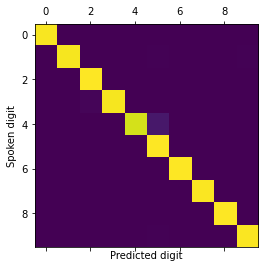

In [16]:
evaluate(net, loader_val)

In [17]:
### Load test cases
paths_wav_test = np.array([f"own_recordings/{idx}.wav" for idx in range(10)])
labels_test = np.arange(10)

loader_test = get_data_loader(paths_wav_test, labels_test, stft_param, B=1, do_shuffle=False, do_augment=False)

Overall accuracy (validation): 100.0%
Predicted 10 correctly, 0 incorrectly


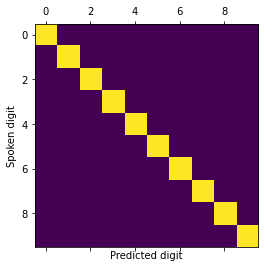

In [18]:
evaluate(net, loader_test)